# Task 1

%
If you haven't already done so, the first task is to form a group of 2-4 people. There is an announcement on Absalon describing how to do this. Make sure that you list the names of all members of the group at the top of the jupyter notebook along with your group number.
%

## Group members:
* Oleksandr kryshtalov [mdq842]  
* Ulrik Bjørn Meelby [na]  


# Task 2

%
For our fake news predictor, we will be using the FakeNewsCorpus dataset as our primary dataset. 
It is available from this github repository:, where you can also find information about how the data is collected, the available fields, etc. In this first milestone, we will work only on a small subset of the FakeNewsCorpus dataset. 
Your first task is to retrieve this subset from https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv and structure/process/clean it. Describe which procedures (and which libraries) you used and why they are appropriate.
%

In order to clean the data we need to first know what the primary goal of cleaning it is. 
In task 3 we have chosen to analyze following questions:
* Are there words that have a higher frequency in fake-news articles over trustworthy ones, and what are those?
* What are the meta_keywords that have the highest inclination to be fake?
* Observe zipf law on english text with given dataset.

All observations require text tokenization, and a way to clean and stem them, in order to not differentiate between words, eg. word and words.

For the cleaning of the text we will be using cleatext.
nltk will be used for tokinization via word_tokenize, and for stemming via the porter stemmer.

In [1]:
# imports:
import requests
import re
import numpy as np
import pandas as pd
import string

from cleantext import clean
import nltk
#from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [2]:
#We get the data from the web 
csvdata = requests.get("https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv")
csvdata

<Response [200]>

In [3]:
# Write csvfile
with open("rawdata.csv","wb") as file:
    file.write(csvdata.content)

# Parse csv into dataframe
dfRaw = pd.read_csv ('rawdata.csv')

# drop some tables for brevity:
df = dfRaw.iloc[: , 1:]
df = df.drop(columns =[ "url", "scraped_at", "scraped_at", "inserted_at", "updated_at", "keywords", "summary"])

# have a peek at the data:
df.head(3)

,id,domain,type,content,title,authors,meta_keywords,meta_description,tags
0,141,awm.com,unreliable,Sometimes the power of Christmas will make you...,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,[''],NaN,NaN
1,256,beforeitsnews.com,fake,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,[''],NaN,NaN
2,700,cnnnext.com,unreliable,Never Hike Alone: A Friday the 13th Fan Film U...,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN


In [4]:
df.type.value_counts()

fake          155
conspiracy     31
political      23
unreliable      6
bias            6
junksci         6
unknown         6
reliable        3
clickbait       1
hate            1
Name: type, dtype: int64

## Cleaning:

In [5]:
# We want to make a pd.Series -> pd.Series function that cleans all the text
# lowercases everything removes urls, emails etc.

def clean_text(textSeries:pd.Series) -> pd.Series:
    def clean_func (text):
        return clean(text,
            fix_unicode=True,            
            to_ascii=True,               
            lower=True,                  
            no_line_breaks=True,        
            no_urls=True,                
            no_emails=True,              
            no_phone_numbers=False,      
            no_numbers=True,             
            no_punct=True,              
            replace_with_punct="",       
            replace_with_url="oURL", # clean_text lowers after tagging for some reason???
            replace_with_email="oEMAIL",
            replace_with_phone_number="oPHONE",
            replace_with_number="oNUM",
            replace_with_digit="0",
            lang="en")
    return textSeries.apply(clean_func)
            
df.content = clean_text(df.content)
df["meta_description"]

0                                                    NaN
1                                                    NaN
2      Never Hike Alone: A Friday the 13th Fan Film  ...
3                                                    NaN
4                                                    NaN
                             ...                        
245                                                  NaN
246                                                  NaN
247    President Donald Trump's reported remarks abou...
248    Antonio Sabato Jr. says Hollywood's liberal el...
249    Former U.S. President Bill Clinton Calls for R...
Name: meta_description, Length: 250, dtype: object

## Tokenization:

In [6]:
nltk.download('punkt') # fix

# Same as before a pd.Series -> pd.Series function.
def tokenize(textSeries:pd.Series) -> pd.Series:
    return pd.Series(textSeries.apply(nltk.tokenize.wordpunct_tokenize),name="tokens")
df["tokens"] = tokenize(df.content)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Oleks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Removal of stopwords:

## Stemming:

In [7]:
# stems all the tokens
def stem (data:pd.Series)-> pd.Series:
    ps = PorterStemmer()
    # function to be applied on each element in series
    def stem (tokens):
        return [ps.stem(token) for token in tokens]
    return pd.Series(data.apply(stem))

# removal of duplicates
def dupeRemove (tokens:pd.Series) -> pd.Series:
    def unDupe (tokens):
        return list(set(tokens))
    return tokens.apply(unDupe)



df["stemmed_with_dupes"] = stem(df.tokens)
df["stemmed"] = dupeRemove(df.tokens)

# Task 3
%\
Now try to explore the FakeNewsCorpus dataset. Make at least three non-trivial observations/discoveries about the data. These observations could be related to outliers, artefacts, or even better: genuinely interesting patterns in the data that could potentially be used for fake-news detection. Examples of simple observations could be how many missing values there are in particular columns - or what the distribution over domains is. Be creative! :).  
%

We found some observations we wanted to look into in Task 2: 
1. Are there words that have a higher frequency in fake-news articles over trustworthy ones, and what are those?
2. What are the meta_keywords that have the highest frequency in biasd/unreliable news?
3. Observe zipf law on english text with given dataset.

These tasks can then be split into smaller tasks:
### 1
* Generate BOW for fake and credibile articles seperatly. 
* For each word find credible/fake delta of the frequencies. 


### 2
* Create BOW for meta keywords for fakes
* Sort 
* Visualize this coefficiant.


## 3
* Create a vocabulary for the entire dataset 
* calculate bag of words for all text. 
* Sort BOW by frequency. 
* plot. 

## Creating BOWs

['michael hayden',
 'sthole countries',
 'daca',
 'haiti',
 'el salvador',
 'africa']

In [43]:
# In the following section we have BOW code, to generate bags of words
# and combining them. As previous we well be using pd.Series as out datatype.
# The code takes a Long time to complete, might want to skip this section and 
# instead unpickle. 


# generate BOW given a set of tokens(with dupes).
def BOWGen(tokenss:pd.Series) -> pd.DataFrame: # with 2 cols for word and count
    
    #generate Bow for 1 list of tokens
    def _BOWGen(tokens:list) -> (list,list): # with 2 cols for word and count
        vocab = []
        freqs = []
        for token in tokens:
            if token not in vocab:
                vocab.append(token)
                freqs.append(1)
            else:
                # increment frequncy counter by one.
                freqs[vocab.index(token)] += 1
        return vocab,freqs
    return tokenss.apply(_BOWGen)

def KWGen(tokenss:pd.Series) -> pd.DataFrame:
    meta_keywords = df.meta_keywords.apply(eval)
    return pd.DataFrame([1]*len(meta_keywords), meta_keywords)
    
    


def BOWGenGlobal(BOWs:pd.Series) -> pd.DataFrame:
    def mergeBOWs(a:(list,list), b):
        vocab, freqs = a
        for (word, count) in zip(b[0],b[1]):
            if word not in vocab:
                vocab.append(word)
                freqs.append(count)
            else:
                freqs[vocab.index(word)] += count
        return vocab, freqs
    
    BOWList = [i for (_, i) in BOWs.items()]
    
    # accumulator
    _BOW = ([],[])
    for idx, BOW in enumerate(BOWList):
        _BOW = mergeBOWs(BOW, _BOW)
        if (idx) % 20 == 0:
            print(f"{idx} out of {len(BOWList)} ")
    out = pd.DataFrame((_BOW)).transpose()
    out.columns = ["word", "count"]
    out["count"] = out["count"].astype(int)
    out["frequency"] = out["count"]/out.size
    print("Done")
    return out
      
# test 
BOWs = BOWGenGlobal(BOWGen(df.tokens.iloc[0:10]))
BOWs.sort_values("count",ascending=False).iloc[0:5]

0 out of 10 
Done


,word,count,frequency
19,the,299,0.096141
94,onum,175,0.056270
39,of,155,0.049839
1,to,112,0.036013
109,in,105,0.033762


In [51]:
BOWGenGlobal(BOWGen(df.meta_keywords.apply(eval))).sort_values(by="count", ascending=False)

0 out of 250 
20 out of 250 
40 out of 250 
60 out of 250 
80 out of 250 
100 out of 250 
120 out of 250 
140 out of 250 
160 out of 250 
180 out of 250 
200 out of 250 
220 out of 250 
240 out of 250 
Done


,word,count,frequency
17,,212,0.566845
26,Politics,10,0.026738
25,News,9,0.024064
100,Beltway Confidential,6,0.016043
99,Opinion,6,0.016043
...,...,...,...
66,Permission marketing,1,0.002674
67,lactose intolerance,1,0.002674
68,irradiated milk,1,0.002674
69,osteoporosis,1,0.002674


## Generating all the BOWs we need
##### This takes a while

In [9]:
use_pickles = True #flag for loading/saving pickles

if not use_pickles:
    # BOW Whole text
    BOW_Whole_text = BOWGenGlobal(BOWGen(df.tokens))

In [58]:
if not use_pickles:
    # BOW keywords fake 
    BOW_keywords_unreliable = BOWGenGlobal( 
        BOWGen(df[df["type"] != "reliable" ].meta_keywords.apply(eval)))
BOW_keywords_unreliable

0 out of 247 
20 out of 247 
40 out of 247 
60 out of 247 
80 out of 247 
100 out of 247 
120 out of 247 
140 out of 247 
160 out of 247 
180 out of 247 
200 out of 247 
220 out of 247 
240 out of 247 
Done


,word,count,frequency
0,bill clinton,1,0.002674
1,myanmar,1,0.002674
2,calls,1,0.002674
3,release,1,0.002674
4,reuters,1,0.002674
...,...,...,...
182,fake news,1,0.002674
183,president trump,1,0.002674
184,vote trump,1,0.002674
185,books on trump,1,0.002674


In [11]:
if not use_pickles:
    # BOW whole text fake
    BOW_Whole_text_fake = BOWGenGlobal(BOWGen(df[df["type"] == "fake"].stemmed))
    # BOW whole text credible
    BOW_Whole_text_reliable = BOWGenGlobal(BOWGen(df[df["type"] == "reliable"].stemmed))

In [12]:
# code for saving/reading dataframe to/from disk:
import pickle

if use_pickles:
    BOW_Whole_text = pickle.load(open('BOW_Whole_text.pickle', 'rb'))
    BOW_keywords_fake = pickle.load(open('BOW_keywords_fake.pickle', 'rb'))
    BOW_Whole_text_fake = pickle.load(open('BOW_Whole_text_fake.pickle', 'rb'))
    BOW_Whole_text_reliable = pickle.load(open('BOW_Whole_text_reliable.pickle', 'rb'))
else:
    pickle.dump(BOW_Whole_text, open('BOW_Whole_text.pickle', 'wb'))
    #pickle.dump(BOW_keywords_fake, open('BOW_keywords_fake.pickle', 'wb'))
    pickle.dump(BOW_Whole_text_fake, open('BOW_Whole_text_fake.pickle', 'wb'))
    pickle.dump(BOW_Whole_text_reliable, open('BOW_Whole_text_reliable.pickle', 'wb'))

BOW_Whole_text.value_counts()

word            count  frequency
$               176    0.005277     1
plan            43     0.001289     1
planes          5      0.000150     1
planet          12     0.000360     1
planetary       1      0.000030     1
                                   ..
feel            93     0.002788     1
feeling         19     0.000570     1
feelingdenial   1      0.000030     1
feelinghealing  2      0.000060     1
™️              2      0.000060     1
Length: 16676, dtype: int64

## Task 3.1

As our final result we will be calculating the frequncy delta between fake and reliable.
And plotting it.

In [13]:
BOW_Whole_text_fake["frequency"] = BOW_Whole_text_fake["count"]/BOW_Whole_text_fake.size
BOW_Whole_text_reliable["frequency"] = BOW_Whole_text_fake["count"]/BOW_Whole_text_fake.size

#BOW_Whole_text_reliable["Windex"] = BOW_Whole_text_reliable["word"]
merged = pd.merge(
    BOW_Whole_text_reliable,
    BOW_Whole_text_fake,
    how='left',
    on="word",
    indicator=False
)

merged["frequency_x"] = merged["frequency_x"].fillna(0)
merged["frequency_y"] = merged["frequency_y"].fillna(0)
merged["count_x"] = merged["count_x"].fillna(0)
merged["count_y"] = merged["count_y"].fillna(0)
merged

,word,count_x,frequency_x,count_y,frequency_y
0,research,1,0.000110,25.0,0.000689
1,than,2,0.000800,50.0,0.001379
2,induced,1,0.000138,1.0,0.000028
3,just,2,0.001379,57.0,0.001572
4,motor,1,0.000689,1.0,0.000028
...,...,...,...,...,...
585,male,1,0.000689,4.0,0.000110
586,experienced,1,0.000028,4.0,0.000110
587,wish,1,0.000138,5.0,0.000138
588,physically,1,0.000441,3.0,0.000083


In [14]:
threeone = pd.concat(
    [
        merged["word"],
        merged["frequency_x"] - merged["frequency_y"], #fake is negative
        merged["count_x"] + merged["count_y"]],
    axis=1,
)
threeone.columns=["word", "freq_delta", "total_count"]

In [15]:
threeone.sort_values(by="freq_delta", ascending=True)[threeone.sort_values(by="freq_delta", ascending=True)["total_count"]>1].head(10)

,word,freq_delta,total_count
164,the,-0.004191,155.0
179,and,-0.004026,153.0
28,for,-0.003667,136.0
96,is,-0.003640,137.0
261,next,-0.003585,134.0
135,a,-0.003474,139.0
145,of,-0.003088,156.0
99,onum,-0.003088,118.0
6,on,-0.003088,122.0
229,that,-0.003005,117.0


In [16]:
threeone.sort_values(by="freq_delta", ascending=False)[threeone.sort_values(by="freq_delta", ascending=False)["total_count"]>1].head(10)

,word,freq_delta,total_count
171,treating,0.004136,4.0
183,location,0.003998,6.0
151,announced,0.003888,13.0
68,dna,0.003778,4.0
66,collapse,0.003529,6.0
263,continue,0.003474,21.0
191,domain,0.003447,6.0
111,rather,0.003336,15.0
130,type,0.003309,13.0
253,despite,0.003281,13.0


The fake news are correlated with common words sich as "and", "the" etc..
While the reliable articles had the highest frequency delta with less used words such as investigator or restore,
This is likley due to the reletivly small sample size for reliable news.

## 3.2

In [60]:
BOW_keywords_unreliable.sort_values(by="count", ascending=False).head(10)

,word,count,frequency
17,,209,0.558824
26,Politics,10,0.026738
25,News,9,0.024064
100,Beltway Confidential,6,0.016043
99,Opinion,6,0.016043
94,Donald Trump,5,0.013369
85,National Security,4,0.010695
136,Conservative Newspaper,4,0.010695
135,Conservative News,4,0.010695
107,ISIS,3,0.008021


As we can se the most common keywords are no keywords. After that we have Politics, news then Beltway Confidential.
These are the most common keywords in articles that are not marked as "Reliable".

## 3.3

<AxesSubplot:>

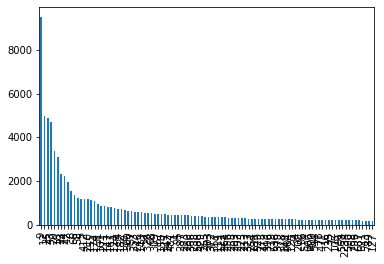

In [17]:
BOW_Whole_text.sort_values(by="count", ascending=False)["count"][:100].plot(kind="bar")

We can se that the top 100 words follows the zipf law. And the histogram seems to match our expectations of zipf's law.